To predict the overall ratings of the players by using attributes in FIFA 23

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('data/FIFA23_official_data.csv')

print(df.head())
print(df.describe())

       ID             Name  Age  \
0  209658      L. Goretzka   27   
1  212198  Bruno Fernandes   27   
2  224334         M. Acuña   30   
3  192985     K. De Bruyne   31   
4  224232       N. Barella   25   

                                              Photo Nationality  \
0  https://cdn.sofifa.net/players/209/658/23_60.png     Germany   
1  https://cdn.sofifa.net/players/212/198/23_60.png    Portugal   
2  https://cdn.sofifa.net/players/224/334/23_60.png   Argentina   
3  https://cdn.sofifa.net/players/192/985/23_60.png     Belgium   
4  https://cdn.sofifa.net/players/224/232/23_60.png       Italy   

                                  Flag  Overall  Potential               Club  \
0  https://cdn.sofifa.net/flags/de.png       87         88  FC Bayern München   
1  https://cdn.sofifa.net/flags/pt.png       86         87  Manchester United   
2  https://cdn.sofifa.net/flags/ar.png       85         85         Sevilla FC   
3  https://cdn.sofifa.net/flags/be.png       91         91    

In [4]:
df.columns.tolist()

['ID',
 'Name',
 'Age',
 'Photo',
 'Nationality',
 'Flag',
 'Overall',
 'Potential',
 'Club',
 'Club Logo',
 'Value',
 'Wage',
 'Special',
 'Preferred Foot',
 'International Reputation',
 'Weak Foot',
 'Skill Moves',
 'Work Rate',
 'Body Type',
 'Real Face',
 'Position',
 'Joined',
 'Loaned From',
 'Contract Valid Until',
 'Height',
 'Weight',
 'Release Clause',
 'Kit Number',
 'Best Overall Rating']

In [5]:
corr_matrix = df.corr(numeric_only=True)['Overall'].sort_values(ascending=False)
print(corr_matrix)

Overall                     1.000000
Potential                   0.706595
Special                     0.697941
Age                         0.595690
International Reputation    0.483563
Skill Moves                 0.440420
Weak Foot                   0.264347
Kit Number                 -0.275838
ID                         -0.531725
Name: Overall, dtype: float64


In [6]:
target_col = 'Overall'

cols_to_drop = [target_col, 'ID', 'Photo', 'Flag', 'Club Logo', 'Preferred Foot', 'Weak Foot', 'Work Rate', 'Body Type', 'Real Face', 'Joined', 'Loaned From', 'Contract Valid Until', 'Height', 'Weight', 'Release Clause', 'Kit Number', 'Best Overall Rating']

cols_to_drop = [c for c in cols_to_drop if c in df.columns]

X = df.drop(columns = cols_to_drop)
y = df[target_col]

print("Feature shape:", X.shape)
print(X.head())

Feature shape: (17660, 11)
              Name  Age Nationality  Potential               Club    Value  \
0      L. Goretzka   27     Germany         88  FC Bayern München     €91M   
1  Bruno Fernandes   27    Portugal         87  Manchester United   €78.5M   
2         M. Acuña   30   Argentina         85         Sevilla FC   €46.5M   
3     K. De Bruyne   31     Belgium         91    Manchester City  €107.5M   
4       N. Barella   25       Italy         89              Inter   €89.5M   

    Wage  Special  International Reputation  Skill Moves  \
0  €115K     2312                       4.0          3.0   
1  €190K     2305                       3.0          4.0   
2   €46K     2303                       2.0          3.0   
3  €350K     2303                       4.0          4.0   
4  €110K     2296                       3.0          3.0   

                      Position  
0  <span class="pos pos28">SUB  
1  <span class="pos pos15">LCM  
2    <span class="pos pos7">LB  
3  <span cl

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error

In [9]:
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

print("Numeric features: ", len(numerical_features))
print("Categorical features: ", len(categorical_features))

Numeric features:  5
Categorical features:  6


In [10]:
numeric_transformer = Pipeline(steps=[
                               ("imputer", SimpleImputer(strategy='median')), 
                               ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)]
)

In [11]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_model)
])

In [12]:
rf_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = rf_pipeline.predict(X_test)

print("Model Performance Metrics:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

from sklearn.metrics import accuracy_score, classification_report
if len(np.unique(y)) < 20:  # If discrete ratings
    y_pred_rounded = np.round(y_pred).astype(int)
    print(f"Accuracy: {accuracy_score(y_test, y_pred_rounded):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_rounded))

Model Performance Metrics:
MAE: 0.8621
RMSE: 1.8081
R² Score: 0.9482


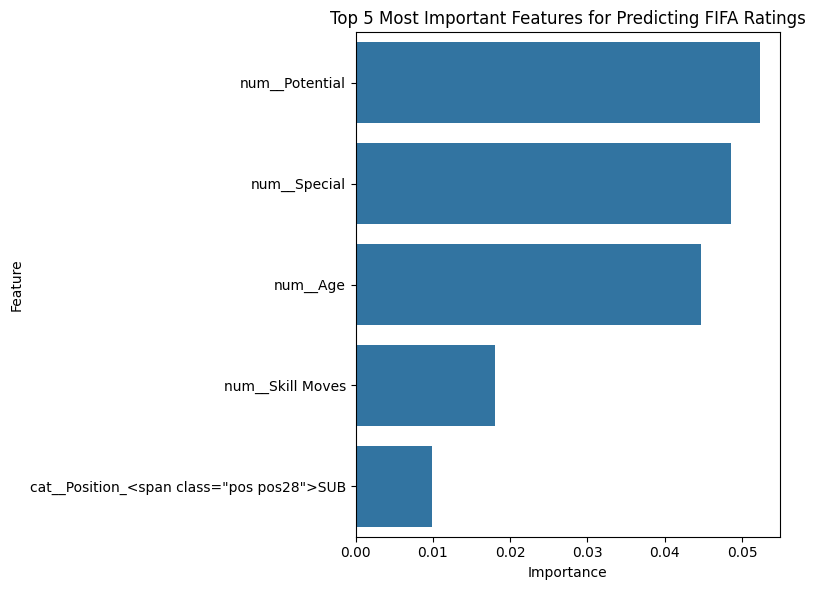

In [14]:
# Get feature names after preprocessing
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get feature importance from Random Forest
importances = rf_pipeline.named_steps['model'].feature_importances_

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 5 features
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df.head(5), x='Importance', y='Feature')
plt.title('Top 5 Most Important Features for Predicting FIFA Ratings')
plt.tight_layout()
plt.show()

In [15]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    rf_pipeline,
    X, y,
    scoring="neg_mean_absolute_error",
    cv=cv,
    n_jobs=-1
)

cv_mae = -cv_scores
print("CV MAE scores:", cv_mae)
print(f"Mean CV MAE: {cv_mae.mean():.4f}")
print(f"Std CV MAE: {cv_mae.std():.4f}")
print(f"Range: {cv_mae.min():.4f} - {cv_mae.max():.4f}")

CV MAE scores: [0.85985277 0.9218573  0.88391846 0.88958097 0.88476784]
Mean CV MAE: 0.8880
Std CV MAE: 0.0198
Range: 0.8599 - 0.9219


In [35]:
# bruno_details = df[df['Name'] == 'Bruno Fernandes'].copy()
# X_bruno = bruno_details[X_cols]

players = ['Bruno Fernandes','K. De Bruyne','T. Alexander-Arnold','L. Messi','H. Kane','K. Mbappé']
X_cols = X_train.columns.tolist()
predictions = []

for player in players:
    player_row = df[df['Name'] == player].copy()

    if len(player_row)==0:
        print(f"⚠️ Player '{player}' not found")
        continue

    # Get features
    X_player = player_row[X_cols]

    # Actual overall
    y_actual = player_row['Overall'].iloc[0]

    # Predicted overall
    y_pred = rf_pipeline.predict(X_player)[0]
    
    predictions.append({
        'Player': player,
        'Actual': y_actual,
        'Predicted': y_pred,
        'Error': y_actual - y_pred
    })

results_df = pd.DataFrame(predictions)
print(results_df[['Player', 'Actual', 'Predicted', 'Error']].to_string(index=False))

             Player  Actual  Predicted  Error
    Bruno Fernandes      86         86      0
       K. De Bruyne      91         88      3
T. Alexander-Arnold      87         87      0
           L. Messi      91         91      0
            H. Kane      89         89      0
          K. Mbappé      91         91      0


In [ ]:
random_players = df.sample(n=10, random_state=42)

predictions = []

for idx, player_row in random_players.iterrows():
    # Convert Series to DataFrame for prediction
    X_player = pd.DataFrame([player_row[X_train.columns]])
    
    # Get player name
    player_name = player_row['Name'] if 'Name' in df.columns else f"Player_{idx}"
    
    # Predict
    y_pred = rf_pipeline.predict(X_player)[0]
    
    predictions.append({
        'Player': player_name,
        'Actual': player_row['Overall'],
        'Predicted': y_pred,
        'Error': player_row['Overall'] - y_pred
    })

random_results = pd.DataFrame(predictions)
print(random_results[['Player', 'Actual', 'Predicted', 'Error']].to_string(index=False))

         Player  Actual  Predicted  Error
22 C. Van Daele      58         58      0
 22 I. Violante      61         61      0
  21 C. Higuera      63         63      0
 Junior Messias      78         76      2
    10 H. Hahne      56         67    -11
       E. Muñoz      69         65      4
     R. Holding      77         79     -2
       P. López      67         67      0
     Luis Milla      79         78      1
    J. Perruzza      58         58      0


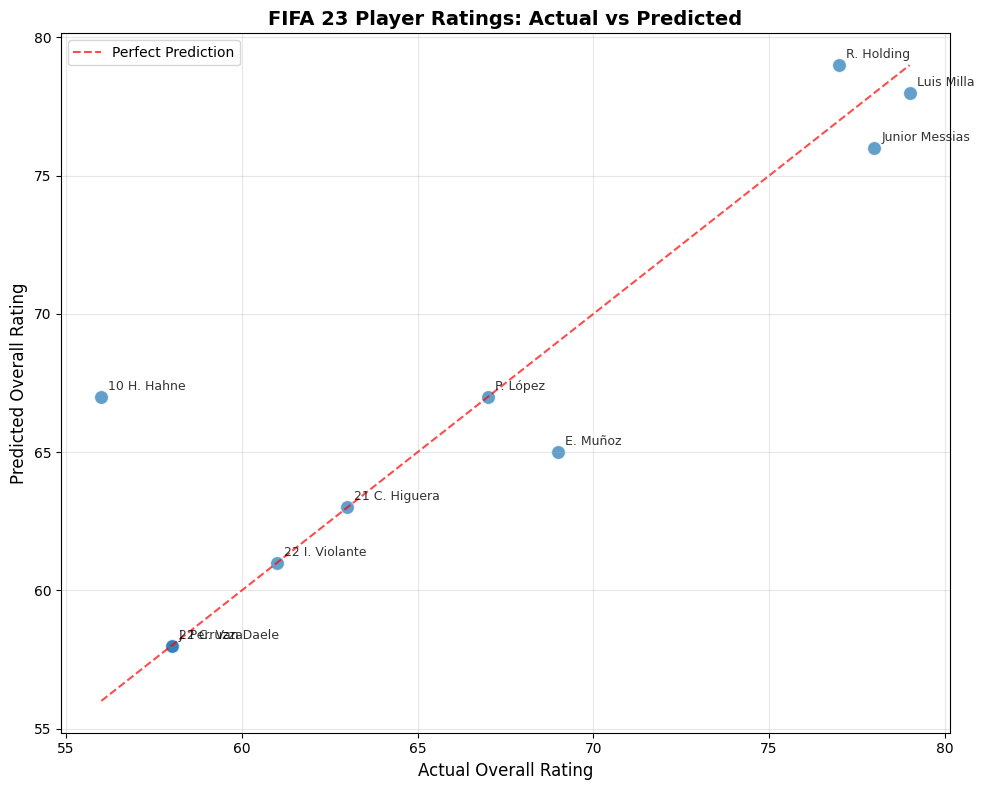

In [41]:
# Create the plot
plt.figure(figsize=(10, 8))

# Scatter plot
sns.scatterplot(x='Actual', y='Predicted', data=random_results, alpha=0.7, s=100)

# Add perfect prediction line (y=x)
max_val = max(random_results['Actual'].max(), random_results['Predicted'].max())
min_val = min(random_results['Actual'].min(), random_results['Predicted'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect Prediction')

# Customize
plt.xlabel('Actual Overall Rating', fontsize=12)
plt.ylabel('Predicted Overall Rating', fontsize=12)
plt.title('FIFA 23 Player Ratings: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

# Add player names as annotations
for idx, row in random_results.iterrows():
    plt.annotate(row['Player'], 
                 (row['Actual'], row['Predicted']),
                 xytext=(5, 5), 
                 textcoords='offset points',
                 fontsize=9,
                 alpha=0.8)

plt.tight_layout()
plt.show()